## Config

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
from sklearn.model_selection import train_test_split

import polaris as po
from polaris.hub.client import PolarisHubClient

import tanimoto_gp
from utils.misc import optimize_params, smiles_to_fp, test_log_likelihood

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from functools import partial
import warnings
warnings.filterwarnings("ignore")

/home/wvir/miniconda3/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up Seaborn plotting style
sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

## Helpers

In [43]:
def natural_params(gp_params):
    """Returns the natural parameters (after softplus transform, positive values)"""
    return [
        float(tanimoto_gp.TRANSFORM(gp_params.raw_amplitude)),
        float(tanimoto_gp.TRANSFORM(gp_params.raw_noise))
        ]

def get_raw_params(natural_amplitude, natural_noise):
    """Returns the raw parameters (before softplus transform)"""
    return tanimoto_gp.TanimotoGP_Params(
        raw_amplitude=jnp.log(jnp.exp(natural_amplitude) - 1),
        raw_noise=jnp.log(jnp.exp(natural_noise) - 1)
    )

def find_first_below_threshold(arr, threshold):
    for i in range(len(arr)):
        if arr[i] < threshold:
            return i
    return len(arr)  # If no value is found below threshold

def find_all_below_threshold(arr, threshold):
    return [i for i in range(len(arr)) if arr[i] < threshold]

def optimize_params(gp, gp_params, tol=1e-3, max_iters=1000):
    """
    Optimize GP parameters until convergence or max steps reached
    
    Args:
        gp: Gaussian Process instance
        gp_params: Initial parameters
        tol: Tolerance for convergence (default 1e-3)
        max_steps: Maximum optimization steps (default 1000)
    """

    print(f"Start MLL: {gp.marginal_log_likelihood(params=gp_params)}")

    optimizer = optax.adam(1e-2)
    opt_state = optimizer.init(gp_params)

    mll, nat_params_over_time, raw_params_over_time, norms = [], [], []

    @jax.jit
    def step(params, opt_state):
        loss, grads = jax.value_and_grad(lambda x: -gp.marginal_log_likelihood(x))(params)
        grad_norm = jnp.linalg.norm(jnp.array(grads))
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, grad_norm, loss

    # Run optimization loop
    for i in range(max_iters):

        gp_params, opt_state, grad_norm, loss = step(gp_params, opt_state)

        if i % 100 == 0:
            nat_params = natural_params(gp_params)
            curr_mll = gp.marginal_log_likelihood(gp_params)

            print(f"Iter: {i} | Params: {nat_params} | MLL: {curr_mll:0.5f} | Grad Norm: {grad_norm:0.5f}")

            mll.append(curr_mll)
            nat_params_over_time.append(nat_params)
            norms.append(grad_norm)

        if grad_norm < tol:
            print(f"Converged after {i+1} steps, gradient norm = {grad_norm}")
            break

    print(f"End MLL (after optimization): {-loss}")
    print(f"End GP parameters (after optimization): {gp_params}")

    return gp_params, mll, nat_params_over_time, raw_params_over_time, norms

def compute_tlls(params, smiles_train, smiles_test, y_train, y_test):

    n = len(smiles_test)
    tlls = []

    gp = tanimoto_gp.TanimotoGP(smiles_to_fp, smiles_train, y_train)

    for i, param in enumerate(params):
        
        gp_params = get_raw_params(param[0], param[1])

        mean, var = gp.predict_y(gp_params, smiles_test, full_covar=True)

        new_tll = test_log_likelihood(smiles_test, mean, var, y_test)

        tlls.append(new_tll / n)
    
    return tlls

In [70]:
def make_plot_1(mll, grad_norms):
    threshold = find_first_below_threshold(grad_norms, 1e-3)
    threshold2 = find_all_below_threshold(grad_norms, 1e-4)
    idxs = find_all_below_threshold(grad_norms, 1e-3)

    n = 18

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    ax[0].plot(np.arange(100)*100, mll)

    ax[0].set_title("MLL")


    ax[1].plot(np.arange(n, 100)*100, mll[n:])
    ax[1].axvline(threshold*100, color='red', ls='dashed', lw=.75, label='1e-3')
    ax[1].axvline(idxs[-5]*100, color='red', ls='dashed', lw=.75, label='1e-3')
    ax[1].axvline(threshold2[0]*100, color='darkgreen', ls='dashed', lw=.75, label='1e-4')
    ax[1].axvline(threshold2[-3]*100, color='darkgreen', ls='dashed', lw=.75, label='1e-4')

    ax[1].set_xlabel("Iter", fontsize=12)
    ax[1].set_title("MLL (iters after 2000)")


    ax[2].plot(np.arange(28, 100)*100, grad_norms[28:])
    ax[2].axvline(threshold*100, color='red', ls='dashed', lw=.75)
    ax[2].axvline(idxs[-5]*100, color='red', ls='dashed', lw=.75, label='1e-3')
    ax[2].axvline(threshold2[0]*100, color='darkgreen', ls='dashed', lw=.75)
    ax[2].axvline(threshold2[-3]*100, color='darkgreen', ls='dashed', lw=.75, label='1e-4')

    ax[2].set_title("Grad Norms")
    ax[2].legend(bbox_to_anchor=(1, 0.75))

    plt.tight_layout()

def make_plot_2(params):
    amps = np.array(params)[:, 0]
    noise = np.array(params)[:, 1]

    amps_raw = np.log(np.exp(amps) - 1)
    noise_raw = np.log(np.exp(noise) - 1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    ax[0].plot(amps, noise, color='firebrick', label='ecfp-sparse')
    ax[0].scatter(amps[0], noise[0], marker='x', color='firebrick', label='Start')
    ax[0].scatter(amps[-1], noise[-1], color='firebrick', label='End')

    ax[0].set_xlabel("Amplitude")
    ax[0].set_ylabel("Noise")
    ax[0].set_title("Noise vs Amplitude over time")

    ax[1].plot(amps_raw, noise_raw, color='firebrick', label='ecfp-sparse')
    ax[1].scatter(amps_raw[0], noise_raw[0], marker='x', color='firebrick', label='Start')
    ax[1].scatter(amps_raw[-1], noise_raw[-1], color='firebrick', label='End')

    ax[1].set_xlabel("Amplitude (Raw)")
    ax[1].set_ylabel("Noise (Raw)")
    ax[1].set_title("Raw Noise vs Amplitude over time")
    ax[1].legend();

def make_plot_3(tll, tlls):

    n=20

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    ax.plot(np.arange(100)*100, tlls, color='midnightblue', lw=0.75, label='TLL')
    ax.axhline(tll, color='orange', ls='dashed', lw=0.75, label=f'Baseline: {tll:0.3f}')
    
    ax.set_title("TLL")
    ax.legend()

    # ax[1].plot(np.arange(n, 100)*100, tlls[n:], color='midnightblue', lw=0.75, label='TLL')

    # # ax[0].text(x=75*100, y=tll, s=f"Baseline: {tll:0.5f}")

    # ax[1].set_xlabel("Iter")
    # ax[1].set_title("TLL (iters after 2000)")

## Data

In [45]:
client = PolarisHubClient()
client.login()

dataset = po.load_dataset("biogen/adme-fang-v1")

print(f"Dataset size: {dataset.size()}")

2025-01-31 08:00:36.708 | SUCCESS  | polaris.hub.client:login:268 - You are successfully logged in to the Polaris Hub.


⠹ Fetching dataset... 

2025-01-31 08:00:37.782 | INFO     | polaris._artifact:_validate_version:84 - The version of Polaris that was used to create the artifact (dev) is different from the currently installed version of Polaris (0.9.1).
2025-01-31 08:00:37.790 | INFO     | polaris.mixins._checksum:verify_checksum:65 - To verify the checksum, we need to recompute it. This can be slow for large datasets.


✅ SUCCESS: Fetched dataset.
 
Dataset size: (3521, 9)


In [46]:
# Get all SMILES strings and logP values from dataset
X = [dataset.get_data(
    row=dataset.rows[i],
    col='MOL_smiles'
    ) for i in range(dataset.size()[0])]

y = [dataset.get_data(
    row=dataset.rows[i],
    col='LOG_SOLUBILITY'
    ) for i in range(dataset.size()[0])]

In [47]:
# Filter molecules with NaN logP values
filter = ~np.isnan(y)

X = np.array([i for idx, i in enumerate(X) if filter[idx]])
y = np.array([i for idx, i in enumerate(y) if filter[idx]])

print(f"Number of molecules after filtering NaNs: {len(X)}")

Number of molecules after filtering NaNs: 2173


In [48]:
smiles_train, smiles_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

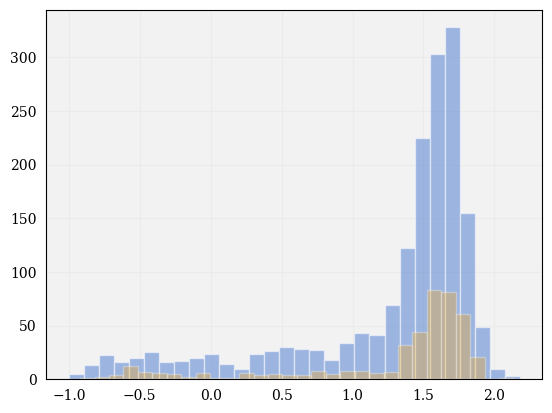

In [49]:
plt.hist(y_train, bins=30, alpha=0.5)
plt.hist(y_test, bins=30, alpha=0.3, color='orange');

In [50]:
amp_baseline = y_train.var()
noise_baseline = 0.1*amp_baseline

gp_baseline = tanimoto_gp.TanimotoGP(smiles_to_fp, smiles_train, y_train)
baseline_params = get_raw_params(amp_baseline, noise_baseline)

n = len(smiles_test)
mean, var = gp_baseline.predict_y(baseline_params, smiles_test, full_covar=True)
tll = test_log_likelihood(smiles_test, mean, var, y_test) / n

## GP Params

In [ ]:
# gp = tanimoto_gp.TanimotoGP(smiles_to_fp, smiles_train, y_train)

# gp_params = tanimoto_gp.TanimotoGP_Params(raw_amplitude=jnp.asarray(-1.0), raw_noise=jnp.asarray(1e-2))

# gp_params, mll, params_over_time, grad_norms = optimize_params(gp, gp_params, tol=1e-5, max_iters=10000)

# tlls = compute_tlls(params, smiles_train, smiles_test, y_train, y_test)

# data = {
#     'mll'           :   mll,
#     'params'        :   params,
#     'grad_norms'    :   grad_norms,
#     'tlls'          :   tlls
# }

# with open(f'data/param-diagnostics', 'wb') as file:
#     pickle.dump(data, file)

In [38]:
with open('data/param-diagnostics', 'rb') as file:
    data = pickle.load(file)

mll, params, grad_norms, tlls = data['mll'], data['params'], data['grad_norms'], data['tlls']

## Visualizations

* take inverse softplus of params too, to see them in that space
* plot TLL as well
* increase frequency of evaluations in regions of interest

* are there some kind of numerical issues going on? e.g., amplitude is only storing params with 5 digits of precision

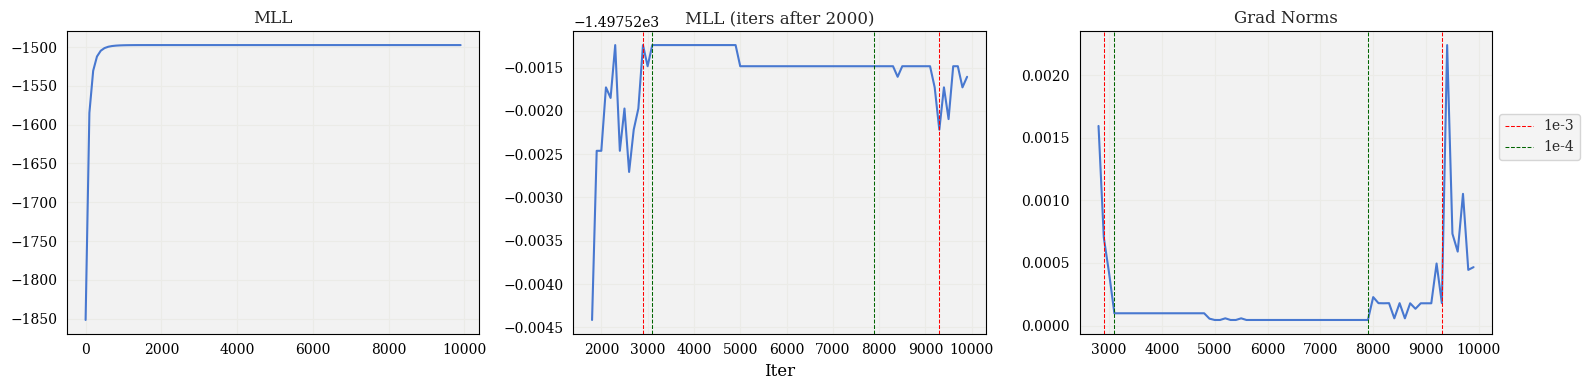

In [51]:
make_plot_1(mll, grad_norms)

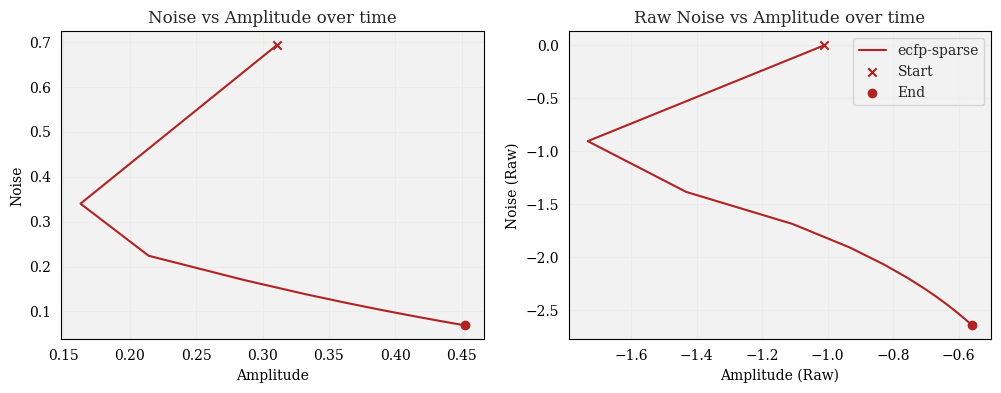

In [52]:
make_plot_2(params)

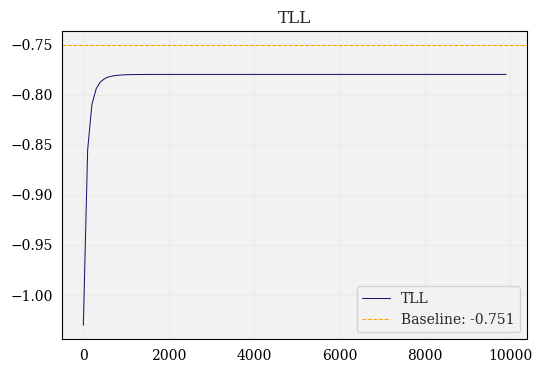

In [71]:
make_plot_3(tll, blls)

In [75]:
x = np.linspace(0.15, 0.5, 100)
y = np.linspace(0.05, 0.7, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

In [76]:
gp = tanimoto_gp.TanimotoGP(smiles_to_fp, smiles_train, y_train)

In [77]:
for i, z in enumerate(Z):
    for j, zz in enumerate(z):
        z_amp, z_noise = X[i,j], Y[i, j]
        gp_params = get_raw_params(z_amp, z_noise)
        Z[i,j] = gp.marginal_log_likelihood(gp_params)

ValueError: setting an array element with a sequence.

In [72]:
amps = np.log(np.exp(np.array(params)[:, 0]) - 1)
noise = np.log(np.exp(np.array(params)[:, 1]) - 1)

In [ ]:
# Create continuous color plot using imshow
plt.figure(figsize=(10, 8))
plt.imshow(Z, 
           extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower',
           cmap='viridis',
           aspect='auto',
           vmin=-1520,
           vmax=-1495)
plt.colorbar(label='Z Value')
plt.plot(amps, noise, color='red', label='Trajectory', ls='dashed', lw=.75)
plt.scatter(amps[0], noise[0], marker='x', color='red', label='Start', s=15)
plt.scatter(amps[-1], noise[-1], color='red', label='End', s=10)
plt.xlabel('Amplitude')
plt.ylabel('Noise')
plt.title('MLL Loss Landscape')
plt.legend()
plt.show()

NameError: name 'x' is not defined

<Figure size 1000x800 with 0 Axes>

In [79]:
np.log(np.exp(params) + 1)

array([[0.86044652, 1.09861417],
       [0.77792138, 0.87761574],
       [0.80601019, 0.81138944],
       [0.84610864, 0.7818801 ],
       [0.87265859, 0.76494274],
       [0.89089892, 0.75446923],
       [0.90391323, 0.7475247 ],
       [0.91349428, 0.74266035],
       [0.92071617, 0.73913322],
       [0.92625048, 0.73650312],
       [0.93053859, 0.7345087 ],
       [0.9338794 , 0.73298022],
       [0.93648551, 0.73180673],
       [0.93851755, 0.73089375],
       [0.94009512, 0.73019397],
       [0.94130832, 0.72966037],
       [0.94223561, 0.72925646],
       [0.94293145, 0.72895104],
       [0.94344436, 0.72872333],
       [0.94382305, 0.72856293],
       [0.94409185, 0.72844393],
       [0.94428127, 0.72836116],
       [0.94440959, 0.72830426],
       [0.94449514, 0.72826805],
       [0.94455015, 0.72824736],
       [0.94458682, 0.72823184],
       [0.94460515, 0.7282215 ],
       [0.94461737, 0.72821633],
       [0.94462349, 0.72821115],
       [0.9446296 , 0.72821115],
       [0.